In [1]:
import csv
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import math
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn import ensemble
import joblib

# load data
data_df = pd.read_csv("out.csv")


In [2]:
# print heads & tails, shape of data
print(data_df.head(2))
print(data_df.tail(2))
print(data_df.shape[0])

   Married  Education  Self_Employed  Loan_Amount  Coapplicant      Term   
0        0          1              0     0.326679            0  0.666667  \
1        1          1              0    -0.101226            1  0.666667   

   Credit_History  Area  Status  
0               1     0     1.0  
1               1     2     0.0  
     Married  Education  Self_Employed  Loan_Amount  Coapplicant      Term   
825        1          1              0     0.482281            1  0.666667  \
826        0          1              1    -0.684733            0  0.166667   

     Credit_History  Area  Status  
825               1     2     NaN  
826               1     2     NaN  
827


In [3]:
# ignore observations with no status
data_df = data_df.dropna()

In [4]:
# print heads & tails, shape of data
print(data_df.head(2))
print(data_df.tail(2))
print(data_df.shape[0])  # 503 observations are left

   Married  Education  Self_Employed  Loan_Amount  Coapplicant      Term   
0        0          1              0     0.326679            0  0.666667  \
1        1          1              0    -0.101226            1  0.666667   

   Credit_History  Area  Status  
0               1     0     1.0  
1               1     2     0.0  
     Married  Education  Self_Employed  Loan_Amount  Coapplicant      Term   
501        1          1              0     1.046337            0  0.666667  \
502        0          1              1    -0.003975            0  0.666667   

     Credit_History  Area  Status  
501               1     0     1.0  
502               0     1     0.0  
503


In [5]:
# Separate into features (X) and target (Y)
X = data_df[["Married", "Education", "Self_Employed", "Loan_Amount", "Coapplicant", "Term", "Credit_History", "Area"]]
Y = data_df["Status"]

print(X.head(5))
print(Y.head(5))

   Married  Education  Self_Employed  Loan_Amount  Coapplicant      Term   
0        0          1              0     0.326679            0  0.666667  \
1        1          1              0    -0.101226            1  0.666667   
2        1          0              0    -0.256828            1  0.666667   
3        0          1              0     0.151627            0  0.666667   
4        1          0              0    -0.743083            1  0.666667   

   Credit_History  Area  
0               1     0  
1               1     2  
2               1     0  
3               1     0  
4               1     0  
0    1.0
1    0.0
2    1.0
3    1.0
4    1.0
Name: Status, dtype: float64


In [6]:
# Separate into train data 80%, test data 20%
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=4)

# Logistic Regression:

In [7]:
# fit Logistic Regression model
log_model = LogisticRegression(random_state=4).fit(X_train, Y_train)

In [8]:
# print mean accuracy of model on testing data
print(log_model.score(X_test, Y_test))

0.801980198019802


In [9]:
# predict testing data and print confusion matrix
predictions = log_model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(Y_test, predictions).ravel()
print((tn, fp, fn, tp))

(16, 19, 1, 65)


In [10]:
# calculate sensitivity and specificity
Sensitivity = tp / (tp + fn)
Specificity = tn / (fp + tn)
print(Sensitivity)
print(Specificity)

0.9848484848484849
0.45714285714285713


# Decision Tree:

In [11]:
# fit Decision Tree model with unlimited depth  -- base model
tree_model = tree.DecisionTreeClassifier().fit(X_train, Y_train)

In [12]:
# print mean accuracy of model on testing data
print(tree_model.score(X_test, Y_test))

0.7227722772277227


In [13]:
def KFold(data_fold, model, cv=5):
    chunks = np.array_split(data_fold, cv)  # split into cv chunks
    correct_sum = 0

    for index in range(cv):
        test_chunk = chunks[index]  # get testing chunk

        train_chunk = []  # get training chunk by appending the non-testing chunks together
        for j in range(cv):
            if j != index:
                train_chunk.append(chunks[j])
        train_chunk = pd.concat(train_chunk)
        
        # separate into X,Y
        X_train_fold = train_chunk[["Married", "Education", "Self_Employed", "Loan_Amount", "Coapplicant", "Term", "Credit_History", "Area"]]
        Y_train_fold = train_chunk["Status"]
        X_test_fold = test_chunk[["Married", "Education", "Self_Employed", "Loan_Amount", "Coapplicant", "Term", "Credit_History", "Area"]]
        Y_test_fold = test_chunk["Status"]
        # fit forest and add the score to the sum
        model.fit(X_train_fold, Y_train_fold)  
        correct_sum = correct_sum + model.score(X_test_fold, Y_test_fold)
    return correct_sum / cv


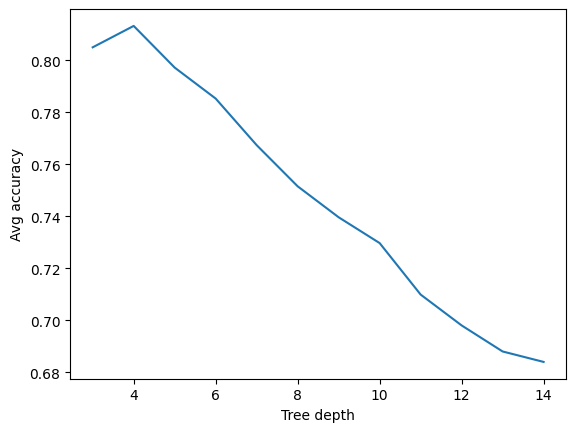

In [14]:
correct_tree = []

# use K-Fold validation on entire dataset with K=12 to find the best depth for the tree
for i in range(3,15):
    treeI = tree.DecisionTreeClassifier(max_depth=i,random_state=4)
    correct_tree.append(KFold(data_fold=data_df, model=treeI, cv=12))

plt.plot(range(3,15), np.array(correct_tree))
plt.xlabel('Tree depth')
plt.ylabel('Avg accuracy')
plt.show()

We can see that the best Tree is at Depth 4, afterwards the model's accuracy goes down because of overfitting

In [15]:
# fit Decision Tree model with the best depth found (depth = 4)
tree_model = tree.DecisionTreeClassifier(max_depth=4).fit(X_train, Y_train)

In [16]:
# print mean accuracy of model on testing data
print(tree_model.score(X_test, Y_test))

0.801980198019802


In [17]:
print(tree_model.feature_names_in_)
print(tree_model.feature_importances_)

['Married' 'Education' 'Self_Employed' 'Loan_Amount' 'Coapplicant' 'Term'
 'Credit_History' 'Area']
[0.         0.         0.03814817 0.07749672 0.03088726 0.0053074
 0.79884756 0.0493129 ]


# Random Forest

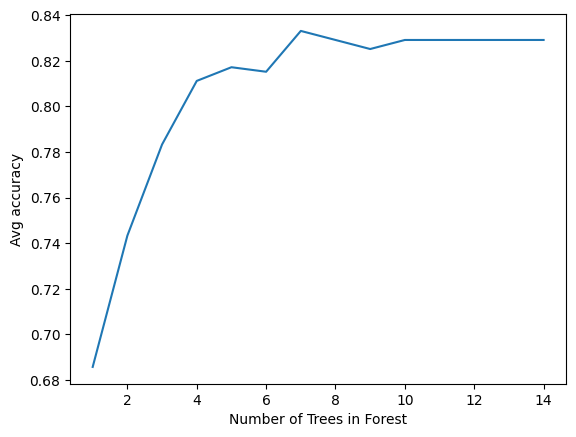

In [18]:
correct_forest = []

# use K-Fold validation on entire dataset with K=12 to find the best number of trees to grow in the forest
for i in range(1,15):
    forestI = ensemble.RandomForestClassifier(n_estimators=i, max_depth=4,random_state=4)
    correct_forest.append(KFold(data_fold=data_df, model=forestI, cv=12))

plt.plot(range(1,15), np.array(correct_forest))
plt.xlabel('Number of Trees in Forest')
plt.ylabel('Avg accuracy')
plt.show()

We can see that the optimal number of trees in the forest is 7

In [19]:
# fit Random Forest model with the best number of trees found (n_estimators = 7)
forest_model = ensemble.RandomForestClassifier(n_estimators=7, max_depth=4, random_state=10).fit(X_train, Y_train)

In [20]:
# print mean accuracy of model on testing data
print(forest_model.score(X_test, Y_test))

0.8118811881188119


In [21]:
# predict testing data and print confusion matrix
predictions = forest_model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(Y_test, predictions).ravel()
print((tn, fp, fn, tp))

(17, 18, 1, 65)


In [22]:
# calculate sensitivity and specificity
Sensitivity = tp / (tp + fn)
Specificity = tn / (fp + tn)
print(Sensitivity)
print(Specificity)  # note the better specificity than the regression model

0.9848484848484849
0.4857142857142857


In [23]:
print(forest_model.feature_names_in_)
print(forest_model.feature_importances_)

['Married' 'Education' 'Self_Employed' 'Loan_Amount' 'Coapplicant' 'Term'
 'Credit_History' 'Area']
[0.03082846 0.04234533 0.00779103 0.07931443 0.0381332  0.05747488
 0.6778164  0.06629627]


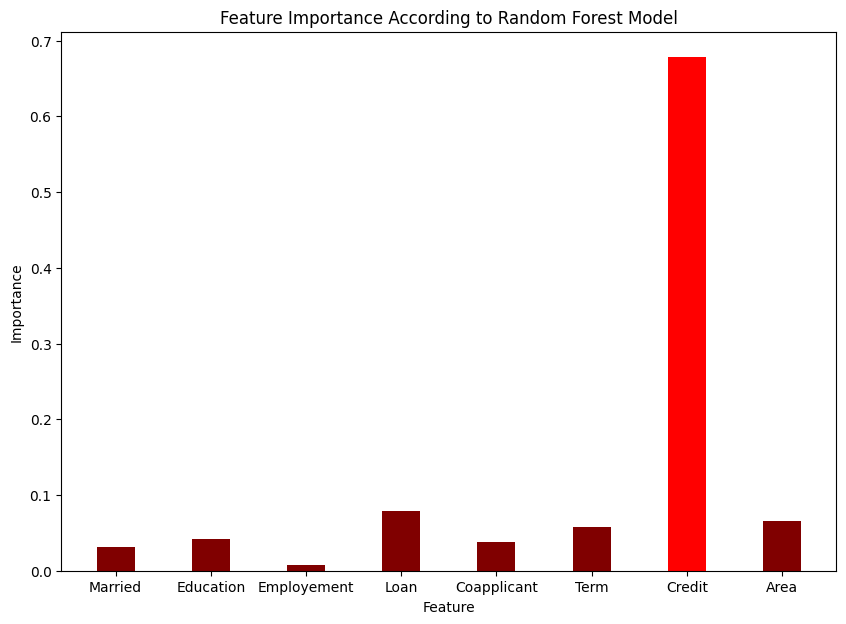

In [24]:
names = ["Married","Education","Employement","Loan","Coapplicant","Term","Credit","Area"]
colors = ["maroon"] * 6 + ["red"] + ["maroon"]
fig = plt.figure(figsize =(10, 7))
plt.bar(names, forest_model.feature_importances_, color = colors, width = 0.4)

plt.ylabel("Importance")
plt.xlabel("Feature")
plt.title("Feature Importance According to Random Forest Model")

plt.show()

We can see from the Feature Importance graph, that the most important feature in terms of Information Gain is the Credit Score feature, afterwards the Loan and Term features. The least important features are the Employement and Married features.

In [25]:
# save the random forest model to a file for later use - use joblib.load to load the model from the file
joblib.dump(forest_model, "./random_forest.joblib")

['./random_forest.joblib']